In [1]:
import gc
import numpy as np
import torch
from itertools import product
from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from warnings import filterwarnings
from torch_geometric.loader import DataLoader
from src.training.train import train
from src.data.loader_paper import GraphDatasetPaper
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/paper.yaml')
set_seed(10)

train_dataset = GraphDatasetPaper(config = config['config'], split = 'train')
val_dataset = GraphDatasetPaper(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])

mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

num_graphs = train_dataset.num_graphs
model = GAE(config, num_graphs).to(device)

In [3]:
history = train(model = model, 
                device = device, 
                params = params, 
                train_loader = train_loader, 
                is_val = False,
                val_loader = val_loader, 
                save_best_model=False,
                config = config['training'])

100%|██████████| 100/100 [00:18<00:00,  5.40it/s, train_loss=0.003042, map_loss=0.000021]


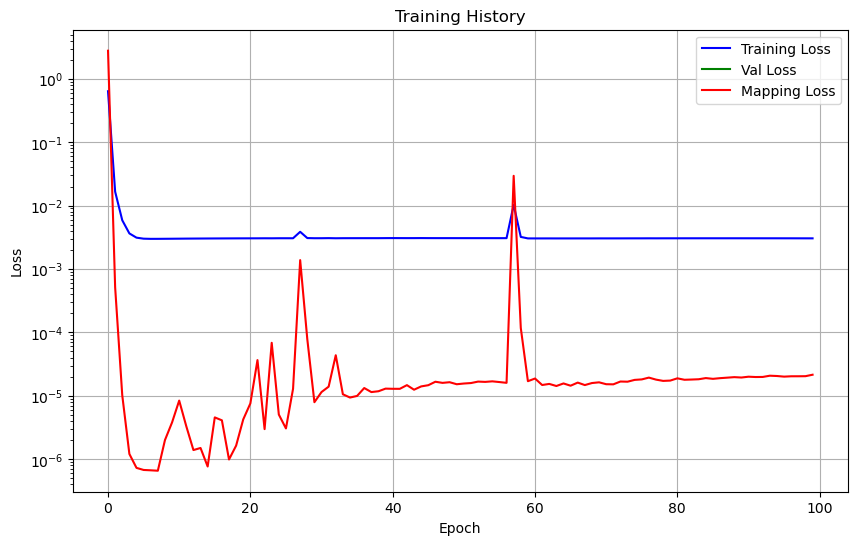

In [3]:
# plot the train history
import matplotlib.pyplot as plt

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='green')
# Plot mapping loss if it exists and is non-zero
if any(history['map_loss']):
    plt.plot(history['map_loss'], label='Mapping Loss', color='red')

# Plot validation loss if it exists
if 'val_loss' in history and history['val_loss']:
    plt.plot(history['val_loss'], label='Validation Loss', color='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()